In [3]:
from typing import *
from math import log2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

class LogPaletteMap:
    def __init__(self, values: np.ndarray, n: int):
        self.palette = sns.color_palette("flare", n_colors=n)
        self.logV_to_hue = {
            logV: self.palette[min(logV, len(self.palette) - 1)]
            for logV in sorted(map(int, np.log2(values.dropna().unique())))}

    def __call__(self, value: float) -> tuple[float, float, float]:
        return self.logV_to_hue[int(np.log2(value))]

    def map_legend(self, handles: list[object], labels: list[str]) -> tuple[list[object], list[str]]:
        return handles[:len(self.palette)], labels[:len(self.palette) - 1] + [f"$\\geq${labels[len(self.palette) - 1]}"]

matplotlib.rcParams.update({"legend.frameon": False, "axes.spines.right": False, "axes.spines.top": False})

In [39]:
df = (pd.read_json("../data/theoretical_models.jsonl", lines=True)
      .pipe(lambda d: d.assign(error_model=1-d["recall_model"]))
      .pipe(lambda d: d.assign(error_simulation=1-d["recall_simulation"]))
)
df.head()

,algorithm,k,n,m,recall_model,recall_simulation,recall_simulation_n,recall_simulation_std,cost_basic,cost_serial,cost_parallel,b,k_b,error_model,error_simulation
0,exact,1,1024,1,1.0,1.0,64,0.0,1024,2048,22,NaN,NaN,0.0,0.0
1,approx,1,1024,1,1.0,1.0,64,0.0,1026,2052,24,2.0,1.0,0.0,0.0
2,approx,1,1024,1,1.0,1.0,64,0.0,1028,2056,24,4.0,1.0,0.0,0.0
3,approx,1,1024,1,1.0,1.0,64,0.0,1032,2064,24,8.0,1.0,0.0,0.0
4,approx,1,1024,1,1.0,1.0,64,0.0,1040,2080,24,16.0,1.0,0.0,0.0


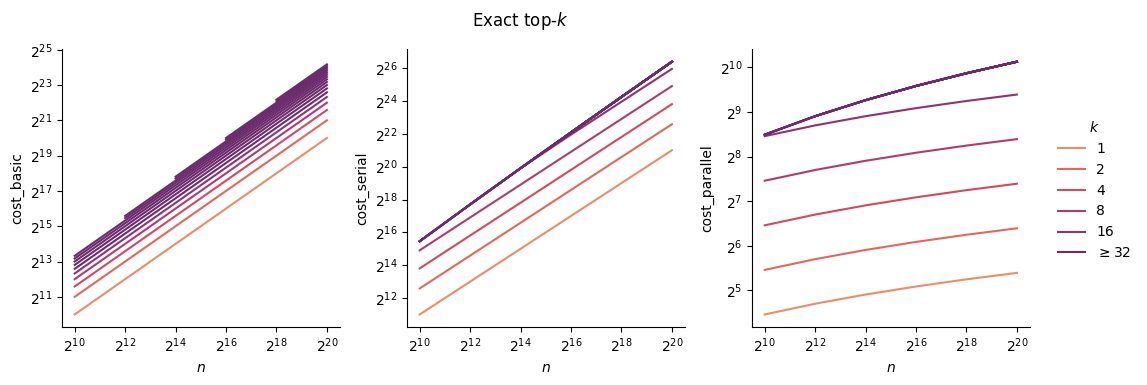

In [34]:
fig, axs = plt.subplots(ncols=3, figsize=(3*3.5, 4))
palette_map = LogPaletteMap(df["k"], n=6)
for y, ax in zip(["cost_basic", "cost_serial", "cost_parallel"], axs):
    for K, g in df[df.algorithm=="exact"].groupby("k"):
        ax.plot(g["n"], g[y], color=palette_map(K), label=str(K))
    ax.set_ylabel(y)
    ax.set_xlabel("$n$")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xticks(df["n"].unique())

fig.legend(*palette_map.map_legend(*axs[0].get_legend_handles_labels()), title="$k$", loc="center left", bbox_to_anchor=(1.0, 0.5))
fig.suptitle("Exact top-$k$", y=0.95)
plt.tight_layout()

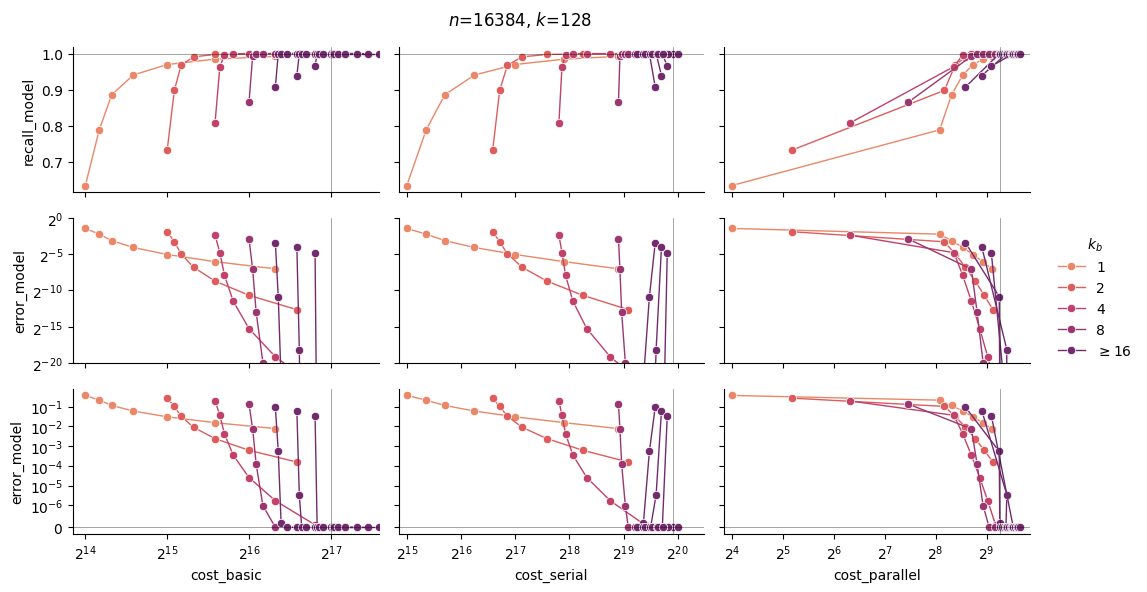

In [66]:
def show_tradeoff(d: pd.DataFrame, cost: str, metric: str, kb_map: LogPaletteMap, ax: matplotlib.axes.Axes) -> None:
    exact = d[d["algorithm"]=="exact"].iloc[0]
    for kb, g in d.groupby("k_b"):
        ax.plot(g[cost], g[metric], color=kb_map(kb), label=f"{kb:.0f}", marker="o", ms=6, mew=.5, mec="w", lw=1)
    ax.axvline([exact[cost]], color="k", lw=.5, alpha=.5)
    ax.axhline([exact[metric]], color="k", lw=.5, alpha=.5)
    ax.set_xlabel(cost)
    ax.set_ylabel(metric)
    ax.set_xscale("log", base=2)
    ax.set_xlim((d[cost].min() * .9, exact[cost] * 1.5))

n, k = (16384, 128)
d = df[(df.n==n) & (df.k==k)]
kb_map = LogPaletteMap(d["k_b"], n=5)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(3*3.5, 2*3), sharey="row", sharex="col")
for metric, axr in zip(["recall_model", "error_model", "error_model"], axs):#, "recall_simulation"
    for cost, ax in zip(["cost_basic", "cost_serial", "cost_parallel"], axr):
        show_tradeoff(d, cost, metric, kb_map, ax=ax)
        if "error" in metric:
            if axr[0] is axs[1, 0]:
                ax.set_yscale("log", base=2)
                ax.set_ylim((2**-20, 1))
            else:
                ax.set_yscale("symlog", base=10, linthresh=10**-6)
        if axr[0] is not axs[-1, 0]:
            ax.set_xlabel("")
        if ax is not axr[0]:
            ax.set_ylabel("")
fig.legend(*kb_map.map_legend(*axs[0, 0].get_legend_handles_labels()), title="$k_b$", loc="center left", bbox_to_anchor=(1.0, 0.5))
fig.suptitle(f"$n$={n}, $k$={k}")
plt.tight_layout()

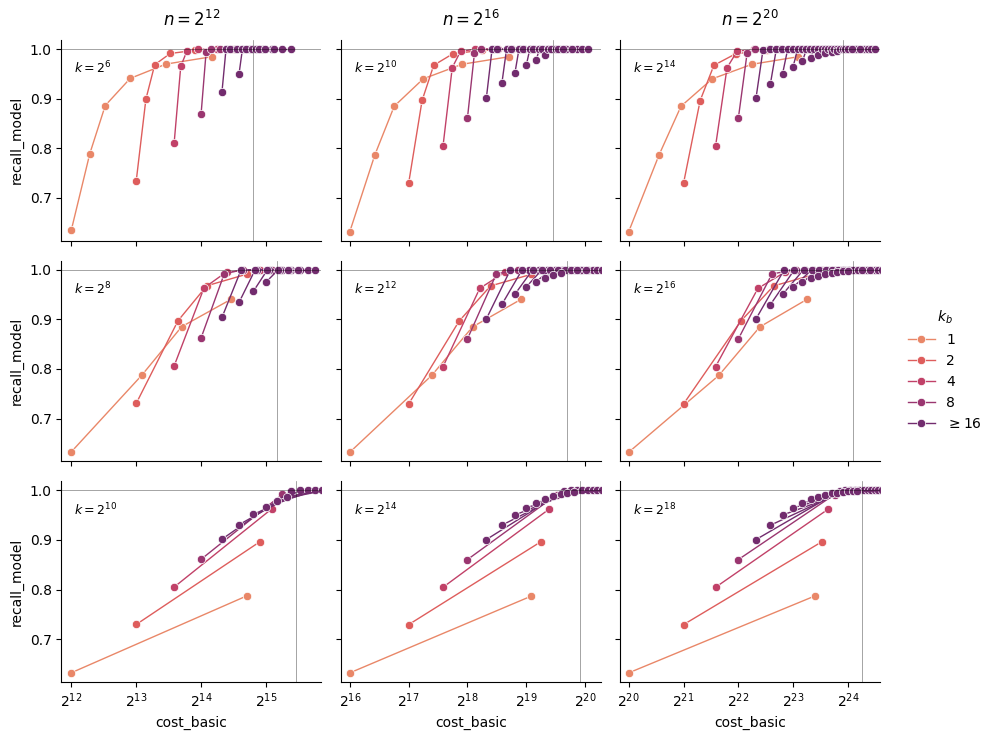

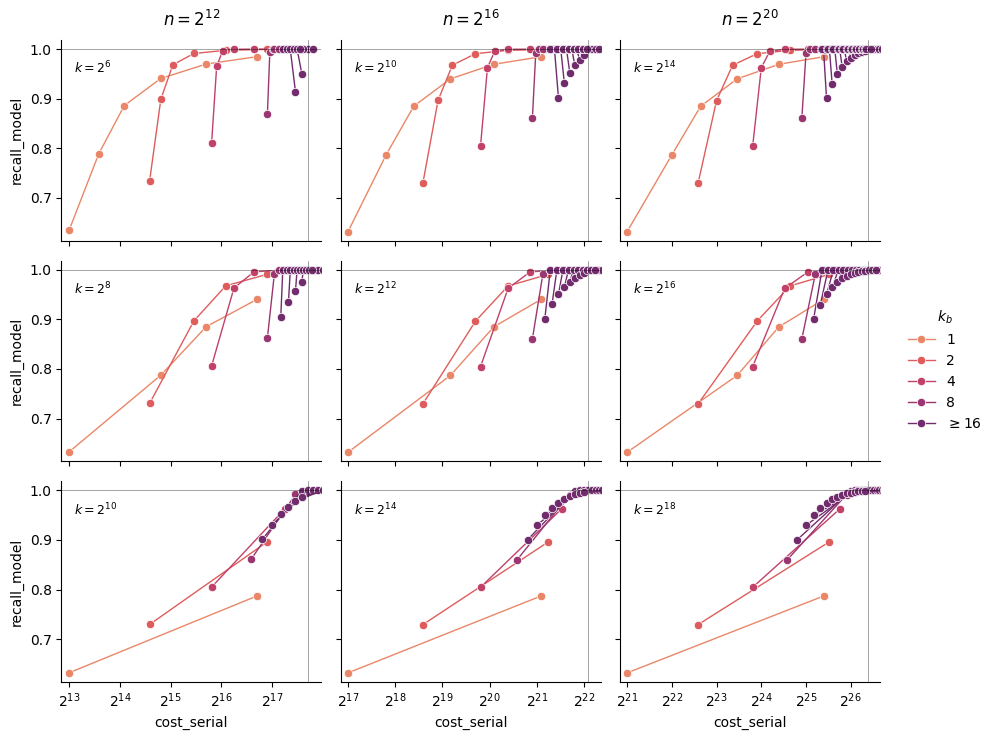

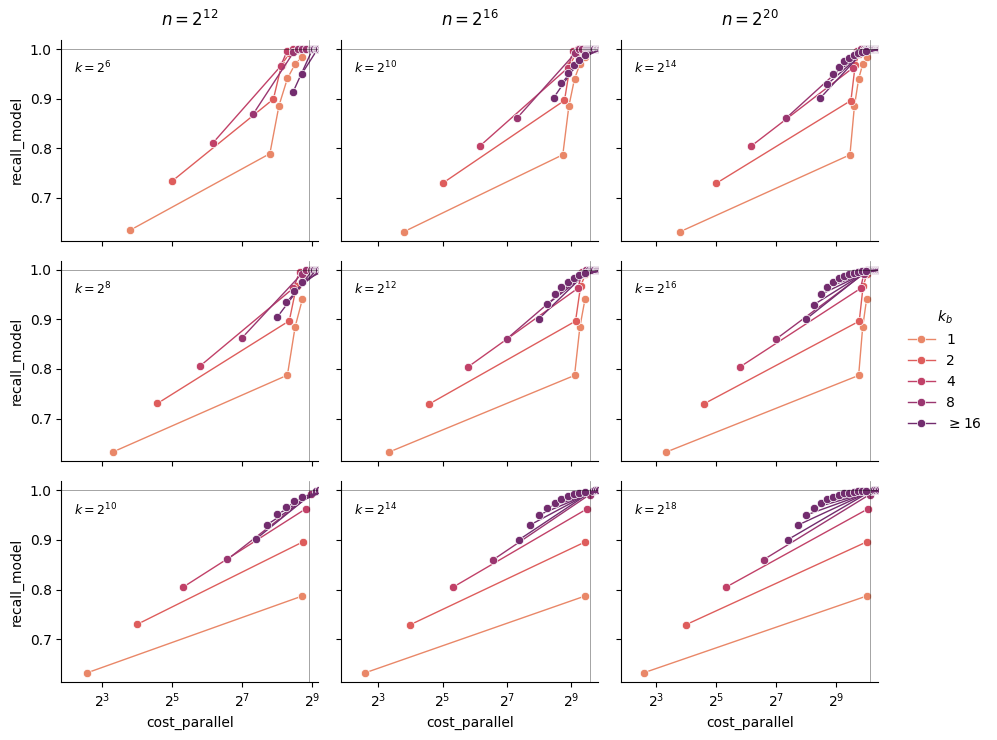

In [67]:
for cost in ["cost_basic", "cost_serial", "cost_parallel"]:
    ns = [2**12, 2**16, 2**20]
    k_over_ns = [1/64, 1/16, 1/4]
    kb_map = LogPaletteMap(df["k_b"], n=5)
    fig, axs = plt.subplots(ncols=len(ns), nrows=len(k_over_ns), figsize=(3*len(ns), 2.5*len(k_over_ns)), sharey=True, sharex="col")
    for k_over_n, axr in zip(k_over_ns, axs):
        for n, ax in zip(ns, axr):
            k = int(k_over_n * n)
            show_tradeoff(df[(df["n"] == n) & (df["k"] == k)], cost=cost, metric="recall_model", kb_map=kb_map, ax=ax)
            if ax is not axr[0]:
                ax.set_ylabel("")
            if k_over_n == k_over_ns[0]:
                ax.set_title(f"$n=2^{{{log2(n):.0f}}}$", pad=10)
            if k_over_n != k_over_ns[-1]:
                ax.set_xlabel("")
            ax.text(0.05, 0.9, f"$k=2^{{{log2(k):.0f}}}$", va="top", ha="left", transform=ax.transAxes, fontsize=9)
            df_col = df[(df["n"]==n)]
            ax.set_xlim(df_col[cost].min() * 0.9, df_col[df_col["algorithm"] == "exact"][cost].max() * 1.2)
    plt.tight_layout()
    fig.legend(*kb_map.map_legend(*axs[0, 0].get_legend_handles_labels()), title="$k_b$", loc="center left", bbox_to_anchor=(1.0, 0.5))